In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math
import scipy.stats
import numpy as np
from scipy.stats import truncnorm
from scipy.stats import multivariate_normal
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
from scipy.stats import norm

In [12]:
N = 10_000
s_1 = np.zeros(N)
s_2 = np.zeros(N)
sig_t = 5
A = np.array([[1, -1]])
t = np.zeros(N)
sigma_s = np.array([[100, 0], [0, 100]]) 
mu_matrix = np.array([100, 100]) 

s_1[0] = 100
s_2[0] = 100
t[0] = 20


In [13]:
def gibbs_sample(N, burn, mu_s1, var_s1, mu_s2, var_s2, y):

    # N total iterations
    # [N - burn] values are returned

    s_1 = np.zeros(N)
    s_2 = np.zeros(N)
    t = np.zeros(N)

    sigma_s = np.array([[var_s1, 0], [0, var_s2]]) 

    # print(f"sigma_s: {sigma_s}\n")

    mu_matrix = np.array([[mu_s1], [mu_s2]]) 

    # print(f"mu matrix: {mu_matrix}\n")

    s_1[0] = np.random.normal(mu_s1, np.sqrt(var_s1))
    s_2[0] = np.random.normal(mu_s2, np.sqrt(var_s2))
    
    mu_t = mu_s1 - mu_s2 # to calc mu_t before game with anterior skills
    sig_t = var_s1 + var_s2

    y = y

    # do heavy calculations before loop
    A = np.array([[1, -1]])
    sigma_st = np.linalg.inv(np.linalg.inv(sigma_s) + A.transpose()*(sig_t**(-1))*A)
    sig_s__mu_mat = np.matmul(np.linalg.inv(sigma_s),mu_matrix)
    A_t__sig_t = A.transpose()*(sig_t**(-1))
  
    for n in range(N-1):
        #print(s_1[:n+1])
        mu_t = s_1[n] - s_2[n] #calc mu_t with posterior skills
        a, b = (-mu_t)/np.sqrt(sig_t), np.inf


        if(y == 1):
            t[n+1] = truncnorm.rvs(a, b, loc= mu_t, scale = np.sqrt(sig_t), size=1)
        else:
            t[n+1] = truncnorm.rvs(-b, a, loc= mu_t, scale = np.sqrt(sig_t), size=1)



        mu_st = np.matmul(sigma_st,(sig_s__mu_mat + A_t__sig_t*t[n+1]))
        # print(mu_st,"\n")
        new_s = np.random.multivariate_normal([mu_st[0][0], mu_st[1][0]], sigma_st)
        s_1[n+1] = new_s[0]
        s_2[n+1] = new_s[1]

    return(s_1[burn:], s_2[burn:], t[burn:])

In [5]:
iter = 10000
burn = 2000
s1, s2, t = gibbs_sample(iter, burn, 25, 25/3, 25, 25/3, 1)

# Sassuolo vs Empoli -> Sassuolo won
# 2
# Sassuolo: [33.51 -> 38.56] & [3.75 -> 2.97]
# Empoli: [20.11 -> 34.07] & [4.49 -> 3.34]

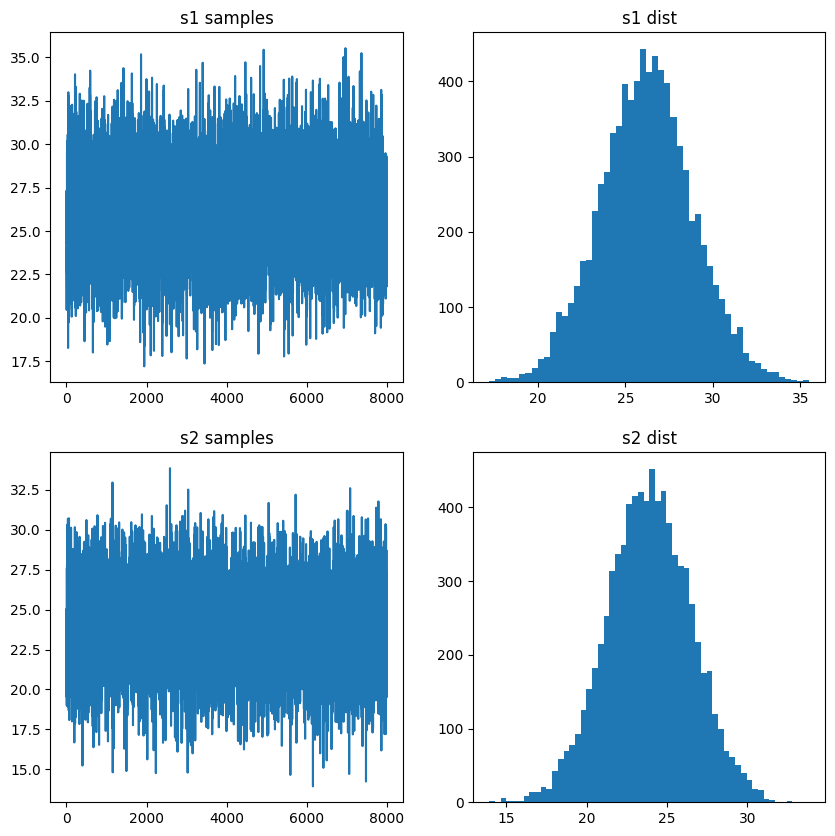

mean_s1 = 26.195408356399646, var_s1 = 7.0428552862248015
mean_s2 = 23.870399012066592, var_s2 = 6.920466393705732


In [6]:


iterations_num = [i + 1 for i in range(iter-burn)]

plt.rcParams['figure.figsize'] = [10, 10]
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(iterations_num,s1)
axs[0, 0].set_title("s1 samples")
axs[0, 1].hist(s1,bins = "auto")
axs[0, 1].set_title("s1 dist")
axs[1, 0].plot(iterations_num,s2)
axs[1, 0].set_title("s2 samples")
axs[1, 1].hist(s2,bins = "auto")
axs[1, 1].set_title("s2 dist")
# axs[2, 0].plot(iterations_num,t)
# axs[2, 0].set_title("t samples")
# axs[2, 1].hist(t,bins = "auto")
# axs[2, 1].set_title("t dist")
plt.show()

print(f"mean_s1 = {np.mean(s1)}, var_s1 = {np.var(s1)}")
print(f"mean_s2 = {np.mean(s2)}, var_s2 = {np.var(s2)}")



# plt.plot(iterations_num,s1[burnin:])
# plt.show()
# plt.hist(s1[burnin:],bins = "auto")
# plt.show()
# plt.plot(iterations_num,s2[burnin:])
# plt.show()
# plt.hist(s2[burnin:],bins = "auto")
# plt.show()
# plt.plot(iterations_num,t[burnin:])
# plt.show()
# plt.hist(t[burnin:],bins = "auto")
# plt.show()

In [14]:
# READ DATA FILE
data = pd.read_csv("nfl_2022.csv", delimiter=";")
print(data)

           Date BLANKS                  team1                 team2  score1  \
0    09/08/2022      -       Los Angeles Rams         Buffalo Bills      10   
1    09/11/2022      -         Houston Texans    Indianapolis Colts      20   
2    09/11/2022      -          Chicago Bears   San Francisco 49ers      19   
3    09/11/2022      -     Cincinnati Bengals   Pittsburgh Steelers      20   
4    09/11/2022      -          Detroit Lions   Philadelphia Eagles      35   
..          ...    ...                    ...                   ...     ...   
266  01/08/2023      -       Seattle Seahawks      Los Angeles Rams      19   
267  01/08/2023      -         Denver Broncos  Los Angeles Chargers      31   
268  01/08/2023      -    Philadelphia Eagles       New York Giants      22   
269  01/08/2023      -  Washington Commanders        Dallas Cowboys      26   
270  01/08/2023      -      Green Bay Packers         Detroit Lions      16   

     score2  
0        32  
1        21  
2        

In [15]:
# MODIFY DATA

#all teams in serie a
teams = data["team1"].unique()

#initial skill, Microsoft sets new players as mu = 25 and sigma = 25/3
init_s = 25
init_var = 25/3

#assign skill and var
team_skills = {}
for team in teams:
    #team_skills = {teamname : [mean, var]}
    team_skills[team] = [init_s, init_var] 



In [16]:
# GIBBS SAMPLE EVERY MATCH

for index, match in data.iterrows():
    # identify teams
    team1 = match['team1']
    team2 = match['team2']
    print(f"{round(100*(index+1)/380,2)}%---------------------------------------------")

    #ignore draws
    if(match["score1"] == match["score2"]):
        print("Draw")
        continue

    # find current team values
    mu_s1, mu_s2 = team_skills[team1][0], team_skills[team2][0]
    var_s1, var_s2 = team_skills[team1][1], team_skills[team2][1]

    #number of iterations in gibbs sampling
    iter = 1000

    #check what team won
    if(match["score1"] > match["score2"]):
        y = 1
        print(f"{team1} vs {team2} -> {team1} won")
    else:
        y = -1
        print(f"{team1} vs {team2} -> {team2} won")

    # call sample func
    s1, s2, t = gibbs_sample(2500, 500, mu_s1, var_s1, mu_s2, var_s2, y)

    

    #calc new mean and var
    new_mu_s1 = np.mean(s1)
    new_mu_s2 = np.mean(s2)
    
    # 
    new_var_s1 = np.var(s1)
    new_var_s2 = np.var(s2)

    print(f"{team1}: [{round(mu_s1,2)} -> {round(new_mu_s1,2)}] & [{round(var_s1,2)} -> {round(new_var_s1,2)}]") 
    print(f"{team2}: [{round(mu_s2,2)} -> {round(new_mu_s2,2)}] & [{round(var_s2,2)} -> {round(new_var_s2,2)}]")


    team_skills[team1] = [new_mu_s1, new_var_s1]
    team_skills[team2] = [new_mu_s2, new_var_s2]


0.26%---------------------------------------------
Los Angeles Rams vs Buffalo Bills -> Buffalo Bills won
Los Angeles Rams: [25 -> 23.86] & [8.33 -> 7.02]
Buffalo Bills: [25 -> 26.22] & [8.33 -> 6.88]
0.53%---------------------------------------------
Houston Texans vs Indianapolis Colts -> Indianapolis Colts won
Houston Texans: [25 -> 23.79] & [8.33 -> 6.97]
Indianapolis Colts: [25 -> 26.2] & [8.33 -> 7.39]
0.79%---------------------------------------------
Chicago Bears vs San Francisco 49ers -> Chicago Bears won
Chicago Bears: [25 -> 26.12] & [8.33 -> 6.82]
San Francisco 49ers: [25 -> 23.91] & [8.33 -> 7.25]
1.05%---------------------------------------------
Cincinnati Bengals vs Pittsburgh Steelers -> Pittsburgh Steelers won
Cincinnati Bengals: [25 -> 23.81] & [8.33 -> 6.92]
Pittsburgh Steelers: [25 -> 26.27] & [8.33 -> 6.76]
1.32%---------------------------------------------
Detroit Lions vs Philadelphia Eagles -> Philadelphia Eagles won
Detroit Lions: [25 -> 23.91] & [8.33 -> 6.9

In [10]:
print(team_skills)

{'Chievo': [22.773990117492882, 0.519595631274489], 'Lazio': [25.107943679377414, 0.1473849002817621], 'Torino': [25.787629337974444, 0.21903173154735317], 'Sassuolo': [23.85779351854466, 0.34613346897075764], 'Parma': [24.06912439791003, 0.20958104664650853], 'Empoli': [25.005864119413417, 0.16821802892521276], 'Bologna': [25.385705861863876, 0.15659542069611915], 'Atalanta': [26.380552868093496, 0.253656953930267], 'Juventus': [25.356724670360602, 0.29788555896333213], 'Napoli': [26.003087263160655, 0.2302868348597014], 'Spal': [24.864832194617914, 0.17241886487052946], 'Udinese': [25.094537498619907, 0.19021769066607627], 'Inter': [25.81744773509795, 0.2035965196866648], 'Genoa': [24.403722160655327, 0.2692864812805658], 'Frosinone': [23.596325559988184, 0.29491904806876823], 'Fiorentina': [23.471595853247024, 0.2502901239962936], 'Cagliari': [24.450258984595283, 0.16335460172046054], 'Roma': [25.9529781550729, 0.21278452733431327], 'Milan': [26.0010875170252, 0.26327817490326094], 

In [20]:
def getrank(mu, var):
    return mu-3*var

ranks = {}


for team in team_skills.keys():
    [mu, var] = team_skills[team]
    ranks[team] = [mu, var, getrank(mu, var)]


sorted_ranks = sorted(team_skills.keys(), key = lambda k: ranks[k][2], reverse=True) 


for i in range(len(sorted_teams)):
    print(f"{sorted_teams[i]}: {round(ranks[sorted_ranks[i]][0],2)}, {round(ranks[sorted_ranks[i]][1],2)}, {round(ranks[sorted_ranks[i]][2], 2)}")

Cincinnati Bengals: 27.28, 0.71, 25.13
San Francisco 49ers: 27.22, 0.79, 24.85
Minnesota Vikings: 26.57, 0.61, 24.75
Buffalo Bills: 27.88, 1.06, 24.71
Dallas Cowboys: 26.21, 0.55, 24.55
Detroit Lions: 26.03, 0.5, 24.53
Washington Commanders: 25.88, 0.48, 24.44
Pittsburgh Steelers: 25.91, 0.52, 24.34
Philadelphia Eagles: 26.45, 0.74, 24.22
Jacksonville Jaguars: 25.87, 0.61, 24.04
Green Bay Packers: 25.57, 0.52, 24.02
New York Giants: 25.47, 0.6, 23.65
New England Patriots: 25.15, 0.56, 23.48
Carolina Panthers: 24.96, 0.49, 23.48
New Orleans Saints: 24.57, 0.43, 23.27
Los Angeles Chargers: 24.65, 0.48, 23.2
Kansas City Chiefs: 27.06, 1.3, 23.16
Cleveland Browns: 24.79, 0.56, 23.11
Miami Dolphins: 24.67, 0.56, 22.99
Seattle Seahawks: 24.57, 0.53, 22.97
Tampa Bay Buccaneers: 24.41, 0.49, 22.96
Baltimore Ravens: 24.94, 0.7, 22.83
New York Jets: 24.16, 0.49, 22.7
Las Vegas Raiders: 24.12, 0.55, 22.47
Atlanta Falcons: 24.09, 0.55, 22.44
Tennessee Titans: 23.65, 0.65, 21.69
Denver Broncos: 23.

In [70]:
def prediction(mu_s1, sig_s1, mu_s2, sig_s2):

    mu_t = mu_s1 - mu_s2
    sig_t = sig_s1 + sig_s2

    #cdf to find prob

    # z-score for 0
    zscore = (0 - mu_t) / np.sqrt(sig_t)
    prob = 1 - scipy.stats.norm.cdf(zscore)

    if prob > 0.5:
        return 1
    else: return -1

In [91]:
# prediction(team_skills["Parma"][0], team_skills["Parma"][1], team_skills["Atalanta"][0], team_skills["Atalanta"][1])
prediction(25, 8, 25 ,8)

-1

In [ ]:
for index, match in data.iterrows():
    
    # identify teams
    team1 = match['team1']
    team2 = match['team2']
    print(f"{round(100*(index+1)/380,2)}%---------------------------------------------")

    #ignore draws
    if(match["score1"] == match["score2"]):
        print("Draw")
        continue

    # find current team values
    mu_s1, mu_s2 = team_skills[team1][0], team_skills[team2][0]
    var_s1, var_s2 = team_skills[team1][1], team_skills[team2][1]

    #number of iterations in gibbs sampling
    iter = 1000

    #check what team won
    if(match["score1"] > match["score2"]):
        y = 1
        print(f"{team1} vs {team2} -> {team1} won")
    else:
        y = -1
        print(f"{team1} vs {team2} -> {team2} won")

    # call sample func
    s1, s2, t = gibbs_sample(2500, 500, mu_s1, var_s1, mu_s2, var_s2, y)

    
    #calc new mean and var
    new_mu_s1 = np.mean(s1)
    new_mu_s2 = np.mean(s2)
    
    # 
    new_var_s1 = np.var(s1)
    new_var_s2 = np.var(s2)

    print(f"{team1}: [{round(mu_s1,2)} -> {round(new_mu_s1,2)}] & [{round(var_s1,2)} -> {round(new_var_s1,2)}]") 
    print(f"{team2}: [{round(mu_s2,2)} -> {round(new_mu_s2,2)}] & [{round(var_s2,2)} -> {round(new_var_s2,2)}]")


    team_skills[team1] = [new_mu_s1, new_var_s1]
    team_skills[team2] = [new_mu_s2, new_var_s2]

In [ ]:
testmean = 25
testvar = 25/3

samps = []

for i in range(1000):
    samps.append(np.random.normal(testmean, np.sqrt(testvar)))


print(np.mean(samps), np.var(samps))

25.16735134734648 8.603343153422891
